# 0. Imports

In [91]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv()
import os

from sklearn.model_selection import train_test_split

In [92]:
target_col = 'expensive'

# 1. Lendo base

In [93]:
path_raw = os.getenv('PATH_TO_SPLIT')
df = pd.read_csv(path_raw, sep=',')
# df = pd.read_csv(path_raw, sep=',')

In [94]:
df = df.drop(columns=['Unnamed: 0'])

In [95]:
df_0 = df.copy()

# 2. Dividindo entre treino e teste

In [96]:
df_1 = df_0.copy() 

In [97]:
X = df_1.drop(columns=[target_col])
y = df_1[target_col]

# Separando os dados em treinamento(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# 3. Treinamento

## Decision Tree

In [113]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [116]:
# from sklearn.tree import plot_tree
# plot_tree(best_model, feature_names=list(X_train.columns))

Accuracy: 0.53


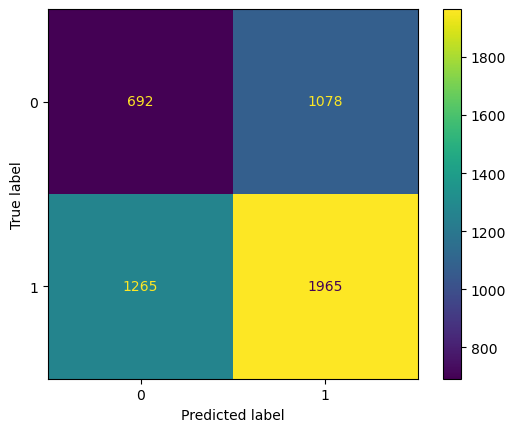

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.39      0.37      1770
           1       0.65      0.61      0.63      3230

    accuracy                           0.53      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.54      0.53      0.54      5000



In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(Y_test, y_pred))

## Random forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, Y_train)

In [111]:
y_pred = rf.predict(X_test)

Accuracy: 0.59


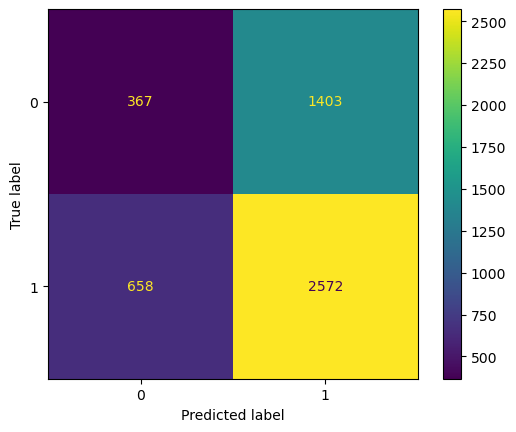

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.21      0.26      1770
           1       0.65      0.80      0.71      3230

    accuracy                           0.59      5000
   macro avg       0.50      0.50      0.49      5000
weighted avg       0.54      0.59      0.55      5000



In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(Y_test, y_pred))

### logist regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# lr = make_pipeline(StandardScaler(), LogisticRegression())

lr = LogisticRegression(max_iter = 20000)

lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

Accuracy: 0.20


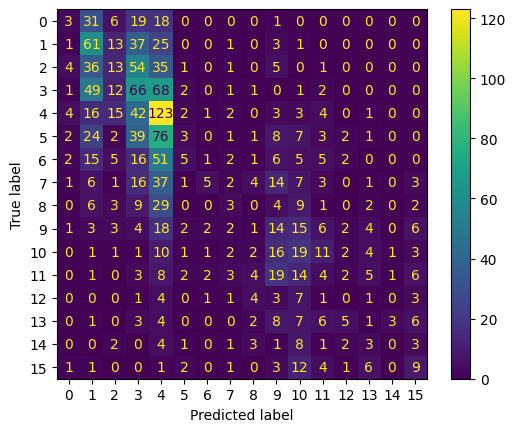

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.04      0.06        78
           1       0.24      0.43      0.31       142
           2       0.17      0.09      0.12       150
           3       0.21      0.33      0.26       203
           4       0.24      0.57      0.34       216
           5       0.14      0.02      0.03       169
           6       0.08      0.01      0.02       116
           7       0.09      0.02      0.03       101
           8       0.00      0.00      0.00        68
           9       0.13      0.17      0.15        83
          10       0.17      0.25      0.20        75
          11       0.08      0.05      0.06        74
          12       0.00      0.00      0.00        26
          13       0.03      0.02      0.03        46
          14       0.00      0.00      0.00        29
          15       0.22      0.22      0.22        41

    accuracy                           0.20      1617
   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(Y_test, y_pred))

In [ ]:
from sklearn.metrics import top_k_accuracy_score

# Calculate top-2 accuracy
y_prob = lr.predict_proba(X_test)
top2_accuracy = top_k_accuracy_score(Y_test, y_prob, k=2)
print(f"Top-2 Accuracy: {top2_accuracy}")

Top-2 Accuracy: 0.35374149659863946


### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
#y_pred = mlp.predict(X_test)

param_grid = {
    'hidden_layer_sizes': [(128, 128,64),(128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)
mlp = grid_search.best_estimator_

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

In [ ]:

# Print the loss curve
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# Print training statistics
print("Training statistics:")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Number of layers: {mlp.n_layers_}")
print(f"Number of outputs: {mlp.n_outputs_}")
print(f"Activation function: {mlp.activation}")
print(f"Learning rate: {mlp.learning_rate}")

# Print training accuracy
train_accuracy = mlp.score(X_train, Y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

In [ ]:
from sklearn.metrics import top_k_accuracy_score

# Calculate top-2 accuracy
y_prob = mlp.predict_proba(X_test)
top2_accuracy = top_k_accuracy_score(Y_test, y_prob, k=2)
print(f"Top-2 Accuracy: {top2_accuracy}")

## Analise Random FLorest

Primeiro devemos notar que a acuracia top2 do random florest, nosso melhor modelo, foi de 0,55 o que, intuitivamente, parece baixo. Uma valor top2 quer dizer que é considerado correto a isntancia que estiver com maior ou segundo maior score, dado pelo modelo. Ou seja, uma variação de 100 mil reais! Acho que um ser humano, com menor numero de features, é capaz de acertar com mais precisão

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(rf, X_test, Y_test ,n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Podemos ver algums comportamentos esperados, como a alta correlação de m^2 e o bairro.

In [ ]:
# Importância das características
importances = rf.feature_importances_
feature_names = X.columns.tolist()
# Mostrar as importâncias
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")

In [ ]:


# Check if the model is multi-output
is_multi_output = hasattr(rf, "n_outputs_") and rf.n_outputs_ > 1

if is_multi_output:
    print("The model is a multi-output model.")
else:
    print("The model is not a multi-output model.")


In [ ]:
rf.n_outputs_

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [1,5,7],grid_resolution=20, target=[1])

In [ ]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [[1,5,7]],grid_resolution=20, target=[1])

In [ ]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [1], kind='both', target=[1])

In [ ]:
from sklearn.decomposition import PCA

# Step 2: Perform PCA
pca = PCA(n_components=2)  # Number of components to keep
principal_components = pca.fit_transform(df_2)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 3: Analyze the results
explained_variance = pca.explained_variance_ratio_

print("Principal Components DataFrame:")
print(pc_df)
print("\nExplained Variance Ratio:")
print(explained_variance)

Gostariamos também de entender relações bivariadas, uma casa com elevador

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(mlp, X_test, Y_test ,n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()